In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## **Backtest Forecast Models**

The goal of time series forecasting is to make accurate predictions about the future. The fast and powerful methods that we rely on in machine learning, such as using train-test splits and k-fold cross-validation, do not work in the case of time series data. This is because they ignore the temporal components inherent in the problem. In this tutorial, you will discover how to evaluate machine learning models on time series data with Python. In the field of time series forecasting, this is called backtesting or hindcasting.

After completing this tutorial, you will know:
- The limitations of traditional methods of model evaluation from machine learning and why evaluating models on out-of-sample data is required.
- How to create train-test splits and multiple train-test splits of time series data for model evaluation in Python.
- How walk-forward validation provides the most realistic evaluation of machine learning models on time series data.

**Model Evaluation**

In applied machine learning, we often split our data into a train and a test set: the training set used to prepare the model and the test set used to evaluate it. We may even use k-fold cross-validation that repeats this process by systematically splitting the data into k groups, each given a chance to be a held out model.

These methods cannot be directly used with time series data. This is because they assume that there is no relationship between the observations, that each observation is independent. This is not true of time series data, where the time dimension of observations means that we cannot randomly split them into groups. Instead, we must split data up and respect the temporal order in which values were observed.

In time series forecasting, this evaluation of models on historical data is called backtesting. In some time series domains, such as meteorology, this is called hindcasting, as opposed to forecasting. We will look at three different methods that you can use to backtest your machine learning models on time series problems. They are:
1. Train-Test split that respect temporal order of observations.
2. Multiple Train-Test splits that respect temporal order of observations.
3. Walk-Forward Validation where a model may be updated each time step new data is received.

In [5]:
series = pd.read_csv("monthly-sunspots.csv",header=0, index_col=0, parse_dates=True,squeeze=True)
series.head()

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
Name: Sunspots, dtype: float64

In [6]:
X = series.values
train_size=int(len(X) * 0.66)
train,test = X[0:train_size], X[train_size:len(X)]

In [13]:
print(f'Observations: {len(X)}')
print(f'Training Observations: {len(train)}')
print(f'Testing Observations: {len(test)}')

Observations: 2820
Training Observations: 1861
Testing Observations: 959


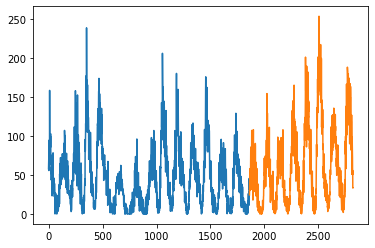

In [17]:
plt.plot(train)
plt.plot([None for i in train] + [x for x in test])
plt.show()

Text(0.5, 1.0, 'Train (blue) and Test (orange) plot')

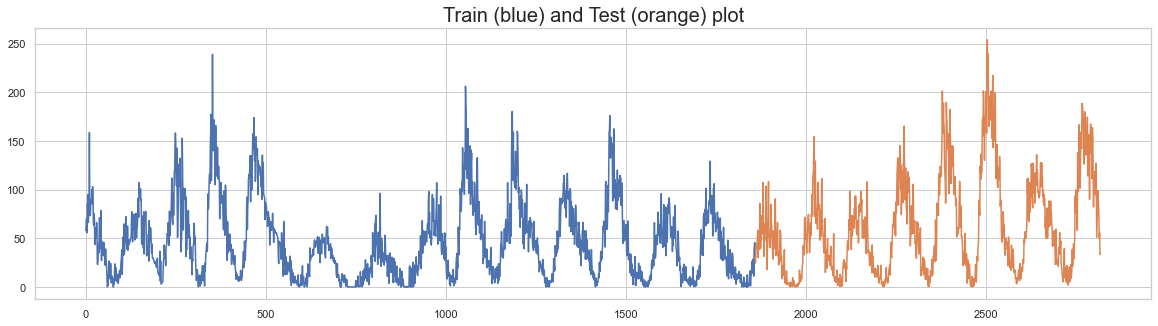

In [25]:
test_plot_data = [None for i in train] + [x for x in test]
fig,ax = plt.subplots(figsize=(20,5))
sns.set_theme(style='whitegrid')
sns.lineplot(data=train)
sns.lineplot(data=test_plot_data)
ax.set_title("Train (blue) and Test (orange) plot",fontdict={'fontsize':20})

**Multiple Train-Test Splits**

We can repeat the process of splitting the time series into train and test sets multiple times. This will require multiple models to be trained and evaluated, but this additional computational expense will provide a more robust estimate of the expected performance of the chosen method and configuration on unseen data. We could do this manually by repeating the process described in the previous section with different split points.

**Alternately, the scikit-learn library provides this capability for us in the TimeSeriesSplit object. You must specify the number of splits to create and the TimeSeriesSplit to return the indexes of the train and test observations for each requested split.** The total number of training and test observations are calculated each split iteration (i) as follows:


$\mathbf{training\_size} = i\times\frac{n\_samples}{n\_splits + 1} + n\_samples \mod(n\_splits + 1) $

$\mathbf{test\_size} = i\times\frac{n\_samples}{n\_splits + 1} $

**where:**

n samples is the total number of observations 

n splits is the total number of splits.

mod -> modulus 

**Use BODMAS**

Observations: 1410
Training Observations: 705
Testing Observations: 705
Observations: 2115
Training Observations: 1410
Testing Observations: 705
Observations: 2820
Training Observations: 2115
Testing Observations: 705


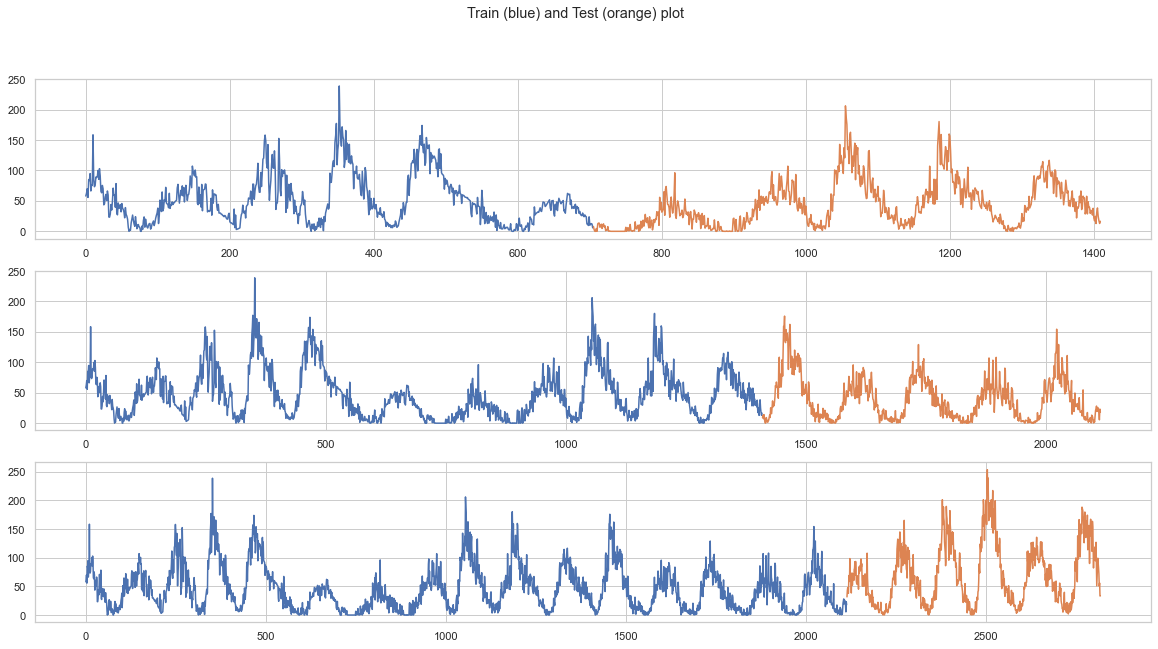

In [45]:
from sklearn.model_selection import TimeSeriesSplit

X = series.values
splits = TimeSeriesSplit(n_splits=3)
fig,ax = plt.subplots(3,1,figsize=(20,10))
sns.set_theme(style='whitegrid')
index = 0 
for train_index, test_index in splits.split(X):
    train = X[train_index]
    test = X[test_index]
    print(f'Observations: {len(train) + len(test)}')
    print(f'Training Observations: {len(train)}')
    print(f'Testing Observations: {len(test)}')
    test_plot_data = [None for i in train] + [x for x in test]
    sns.lineplot(data=train, ax=ax[index])
    sns.lineplot(data=test_plot_data,ax=ax[index])
    fig.suptitle("Train (blue) and Test (orange) plot",fontdict={'fontsize':30})
    index +=1


Using multiple train-test splits will result in more models being trained, and in turn, a more accurate estimate of the performance of the models on unseen data. A limitation of the train-test split approach is that the trained models remain fixed as they are evaluated on each evaluation in the test set. This may not be realistic as models can be retrained as new daily or monthly observations are made available. This concern is addressed in the next section.

**Walk Forward Validation**

In practice, we very likely will retrain our model as new data becomes available. This would give the model the best opportunity to make good forecasts at each time step. We can evaluate our machine learning models under this assumption. There are few decisions to make:

- **Minimum Number of Observations:** First, we must select the minimum number of observations required to train the model. This may be thought of as the window width if a sliding window is used (see next point).
- **Sliding or Expanding Window:** Next, we need to decide whether the model will be trained on all data it has available or only on the most recent observations. This determines whether a sliding or expanding window will be used.

After a sensible configuration is chosen for your test-setup, models can be trained and evaluated.
1. Starting at the beginning of the time series, the minimum number of samples in the window is used to train a model.
2. The model makes a prediction for the next time step.
3. The prediction is stored or evaluated against the known value.
4. The window is expanded to include the known value and the process is repeated (go to step 1.)

In [46]:
n_train = 500
n_records = len(X)

for i in range(n_train, n_records):
    train, test = X[0:i], X[i:i+1]
    print(f"{len(train)} {len(test)}")


500 1
501 1
502 1
503 1
504 1
505 1
506 1
507 1
508 1
509 1
510 1
511 1
512 1
513 1
514 1
515 1
516 1
517 1
518 1
519 1
520 1
521 1
522 1
523 1
524 1
525 1
526 1
527 1
528 1
529 1
530 1
531 1
532 1
533 1
534 1
535 1
536 1
537 1
538 1
539 1
540 1
541 1
542 1
543 1
544 1
545 1
546 1
547 1
548 1
549 1
550 1
551 1
552 1
553 1
554 1
555 1
556 1
557 1
558 1
559 1
560 1
561 1
562 1
563 1
564 1
565 1
566 1
567 1
568 1
569 1
570 1
571 1
572 1
573 1
574 1
575 1
576 1
577 1
578 1
579 1
580 1
581 1
582 1
583 1
584 1
585 1
586 1
587 1
588 1
589 1
590 1
591 1
592 1
593 1
594 1
595 1
596 1
597 1
598 1
599 1
600 1
601 1
602 1
603 1
604 1
605 1
606 1
607 1
608 1
609 1
610 1
611 1
612 1
613 1
614 1
615 1
616 1
617 1
618 1
619 1
620 1
621 1
622 1
623 1
624 1
625 1
626 1
627 1
628 1
629 1
630 1
631 1
632 1
633 1
634 1
635 1
636 1
637 1
638 1
639 1
640 1
641 1
642 1
643 1
644 1
645 1
646 1
647 1
648 1
649 1
650 1
651 1
652 1
653 1
654 1
655 1
656 1
657 1
658 1
659 1
660 1
661 1
662 1
663 1
664 1
665 1
666 

Running the example simply prints the size of the training and test sets created. We can see the train set expanding each time step and the test set fixed at one time step ahead. Within the loop is where you would train and evaluate your model.

Walk-forward validation is the gold standard of model evaluation. It is the k-fold cross-validation of the time series world and is recommended for your own projects.